# Aim

In trying to build a simulation of atmospheric tip-tilts to correct using a Kalman-LQG controller, I've run into problems separating out tip and tilt from a phase screen, and in creating a specified tip or tilt in the focal plane intensity based on the phase at the pupil plane. This notebook demonstrates these problems.

In [1]:
# imports and setup

# I have hcipy as a submodule, so this import may vary
import sys
sys.path.append("..")
from hcipy.hcipy import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage, signal, optimize

pupil_size = 16
focal_samples = 8 # samples per lambda over D
focal_width = 8 # half the number of lambda over Ds
D = 10
D_magic = 1
wavelength = 500e-9 # m
f_sampling = 1000
T = 1
times = np.arange(0, T, 1/f_sampling)
pupil_grid = make_pupil_grid(pupil_size, D_magic)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, focal_samples, focal_width, wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(D_magic)(pupil_grid)
layers = make_standard_atmospheric_layers(pupil_grid)[:1]

In [2]:
def center_of_mass(f):
    # takes in a Field, returns its CM.
    s = f.grid.shape[0]
    x, y = (n.flatten() for n in np.meshgrid(np.linspace(-s/2, s/2-1, s), np.linspace(-s/2, s/2-1, s)))
    return np.array((sum(f*x), sum(f*y)))/sum(f)

conversion = (wavelength / D) * 206265000 / focal_samples
steps = int(f_sampling * T)

In [3]:
tt = [zernike(*ansi_to_zernike(i), D_magic)(pupil_grid) for i in (1, 2)] # tip-tilt phase basis
basis_t = np.array(tt)
basis = basis_t.T
# to_multiply translates from an uncorrected phase screen to one with only TT uncorrected
to_multiply = basis.dot(np.linalg.inv(basis_t.dot(basis)).dot(basis_t))

In [4]:
tt_cms_ls = np.zeros((steps, 2))
for n in range(steps):
    wf = Wavefront(aperture, wavelength)
    for layer in layers:
        layer.evolve_until(times[n])
        wf = layer(wf)
    tt_wf = Wavefront(aperture * np.exp(1j * to_multiply.dot(wf.phase)), wavelength)
    tt_cms_ls[n] = center_of_mass(prop(tt_wf).intensity)
    
tt_cms_ls *= conversion

Text(0.5, 1.0, 'Atmospheric tip-tilts (LS)')

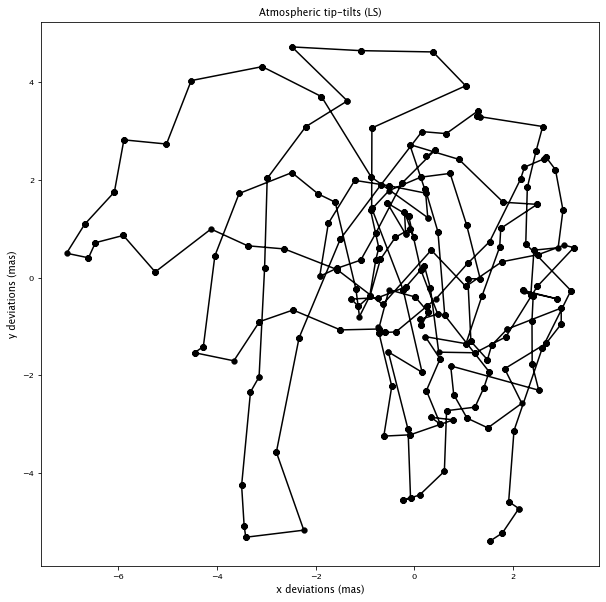

In [5]:
plt.figure(figsize=(10,10))
plt.plot(tt_cms_ls[:,0], tt_cms_ls[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Atmospheric tip-tilts (LS)")

In [6]:
from aberrations import make_2D_vibe_data
vibe_aberrations = make_2D_vibe_data()
combined = tt_cms_ls + vibe_aberrations

Text(0.5, 1.0, 'Vibration tip-tilts')

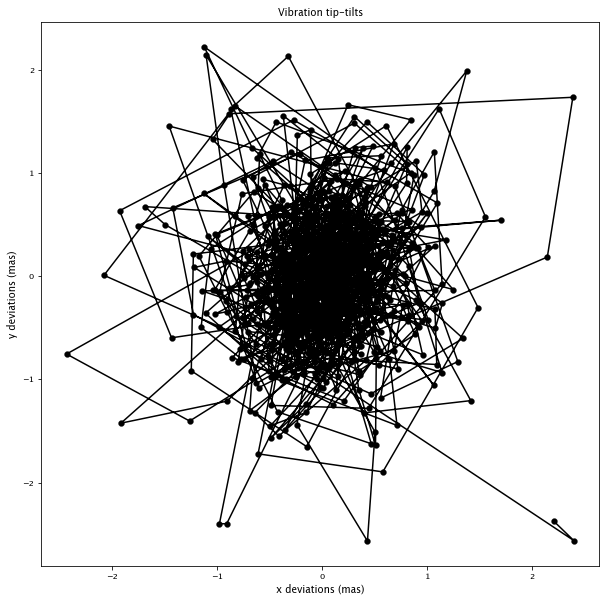

In [7]:
plt.figure(figsize=(10,10))
plt.plot(vibe_aberrations[:,0], vibe_aberrations[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Vibration tip-tilts")

Text(0.5, 1.0, 'Full tip-tilts')

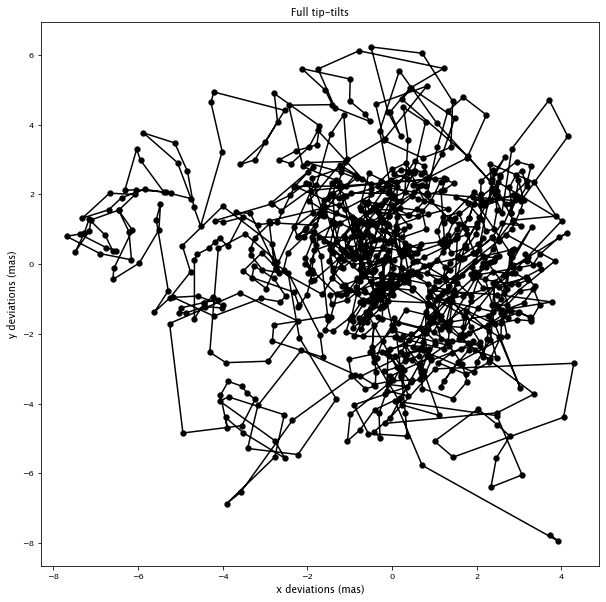

In [8]:
plt.figure(figsize=(10,10))
plt.plot(combined[:,0], combined[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Full tip-tilts")

(1e-07, 58.135047743241564)

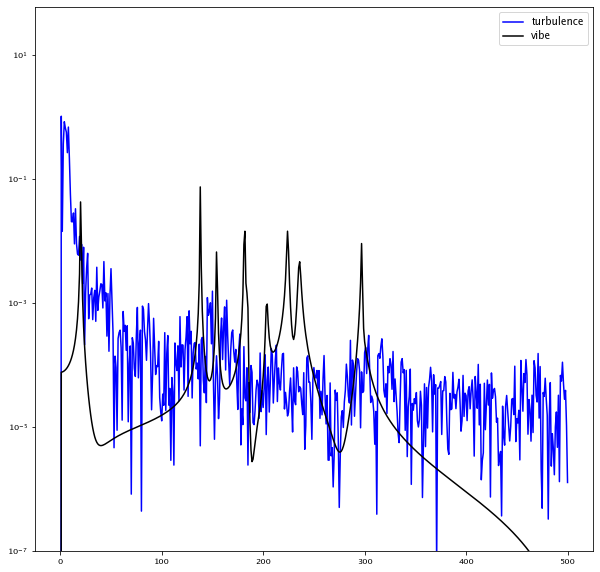

In [9]:
plt.figure(figsize=(10,10))
plt.semilogy(*signal.periodogram(tt_cms_ls[:,0], f_sampling), 'b-', label='turbulence')
plt.semilogy(*signal.periodogram(vibe_aberrations[:,0], f_sampling), 'k-', label='vibe')
#plt.semilogy(*signal.periodogram(combined[:,0], f_sampling), 'r-', label='combined')
plt.legend()
plt.ylim(1e-7)

Thoughts here: we can put an f^-2 averaged power law fit through the low-vibration part, and figure out what the curve is. Then do autoregression?

(1e-07, 32.03315888396134)

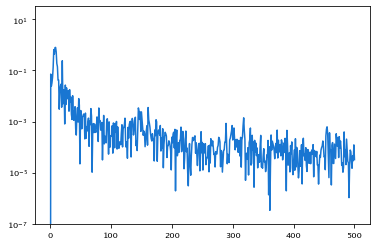

In [12]:
# for now, let's assume that we can perfectly separate out the atmosphere part (it probably won't be a bad fit.)
# my working hypothesis: because we're only looking at TT, only the (0, 1) and (1, 0) terms exist.

freqs, psd_turb_x = signal.periodogram(tt_cms_ls[:,0], f_sampling)
_, psd_turb_y = signal.periodogram(tt_cms_ls[:,1], f_sampling)

plt.semilogy(freqs, psd_turb_y)
plt.ylim(1e-7)

In [ ]:
psd_fit = lambda 